# LLMs for Mental Health Early Detection

## 1. Data Cleaning & Structuring Pipeline

### 1.1 Loading data

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('./beyond_blue_scraping/data/beyondblue.csv')
df.columns

Index(['post_id', 'title', 'author', 'date', 'category', 'preview',
       'post_text', 'num_comments', 'comments_combined', 'url'],
      dtype='object')

In [3]:
df.head()

post_id                                        title          author  \
0        1                     Struggling at the moment            Toby   
1        2                                      Anxiety          Shell1   
2        3                                  overwhelmed  Guest_87295139   
3        4                                      Stalker         G-i-g-i   
4        5  Generalised Anxiety disorder not going good          Lil123   

         date category                                            preview  \
0  2025-07-16  Anxiety  Hello everyone, this is my first post, so I ho...   
1  2025-05-23  Anxiety  Hi my name is Michelle and I have had Anxiety ...   
2  2025-07-14  Anxiety  sorry if this is alot i just rlly need to get ...   
3  2025-07-14  Anxiety  I feel no one is supporting me. I have a stalk...   
4  2025-07-14  Anxiety  Hi, my name is lily. I have no idea what else ...   

                                           post_text  num_comments  \
0  Hello everyone, this is my first post, so I ho...             4   
1  Hi my name is Michelle and I have had Anxiety ...             2   
2  sorry if this is alot i just rlly need to get ...             2   
3  I feel no one is supporting me. I have a stalk...             3   
4  Hi, my name is lily. I have no idea what else ...             2   

                                   comments_combined  \
0  [{"comment_id": "1", "author": "Morph", "times...   
1  [{"comment_id": "1", "author": "Croix", "times...   
2  [{"comment_id": "1", "author": "TrueSeeker", "...   
3  [{"comment_id": "1", "author": "TrueSeeker", "...   
4  [{"comment_id": "1", "author": "TrueSeeker", "...   

                                                 url  
0  https://forums.beyondblue.org.au/t5/anxiety/st...  
1  https://forums.beyondblue.org.au/t5/anxiety/an...  
2  https://forums.beyondblue.org.au/t5/anxiety/ov...  
3  https://forums.beyondblue.org.au/t5/anxiety/st...  
4  https://forums.beyondblue.org.au/t5/anxiety/ge...

In [4]:
df.shape

(6753, 10)

In [5]:
print(df.isna().sum())

post_id              0
title                0
author               0
date                 0
category             0
preview              0
post_text            0
num_comments         0
comments_combined    0
url                  0
dtype: int64


In [6]:
df.shape

(6753, 10)

In [7]:
print((df['comments_combined'].astype(str).str.strip() == "[]").sum())

29


Although there are 29 comments are empty, but we still need the posts. We will remove it after flatten the dataset.

In [8]:
df[['title', 'post_text']].duplicated().sum()

137

In [9]:
# Remove duplicate rows based only on 'title' and 'post_text'
df = df.drop_duplicates(subset=['title', 'post_text'])

print(df.shape)

(6616, 10)


Here we found out there are 137 rows show up multiple times, maybe this problem happens from web scraping, let's drop duplicate here. And there are 6616 rows remain.

In [10]:
# Convert 'created_utc' to datetime if not already
df['date'] = pd.to_datetime(df['date'])

# Check date range in a DataFrame
df['date'].min()  # Earliest date
df['date'].max()  # Latest date

# Get full range info
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Total days: {(df['date'].max() - df['date'].min()).days}")

Date range: 2019-01-06 00:00:00 to 2025-07-18 00:00:00
Total days: 2385


Our data is from 2019 to 2025 and there are total 6752 of posts. 

In [11]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 6616 entries, 0 to 6616
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   post_id            6616 non-null   int64         
 1   title              6616 non-null   object        
 2   author             6616 non-null   object        
 3   date               6616 non-null   datetime64[ns]
 4   category           6616 non-null   object        
 5   preview            6616 non-null   object        
 6   post_text          6616 non-null   object        
 7   num_comments       6616 non-null   int64         
 8   comments_combined  6616 non-null   object        
 9   url                6616 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(7)
memory usage: 568.6+ KB


post_id                           date  num_comments
count  6616.000000                           6616   6616.000000
mean   3309.215840  2022-08-26 00:10:00.725513984      5.410822
min       1.000000            2019-01-06 00:00:00      0.000000
25%    1654.750000            2021-07-26 00:00:00      2.000000
50%    3309.500000            2022-08-29 00:00:00      3.000000
75%    4963.250000            2023-11-04 00:00:00      6.000000
max    6617.000000            2025-07-18 00:00:00     40.000000
std    1910.371392                            NaN      6.924050

In [12]:
df = df[df['author'] != 'BeyondBlue']

In case we lose the guidelines from the website, we drop it here.

### 1.2 Flatten Comments While Retaining Posts

In [13]:
flatten_rows = []

for idx, row in df.iterrows():
    post_id = row['post_id']
    author = row['author']
    category = row['category']
    title = row['title']
    
    # Add the original post
    flatten_rows.append({
        "author": author,
        "post_id": post_id,
        "comment_id": "0", # Main post has no comment_id
        "timestamp": row['date'],
        "category": category,
        "title": title,
        "text": row['post_text'],
        "is_post": True,
        "thread_owner": author
    })
    
    # Flatten comments
    try:
        comments = json.loads(row['comments_combined'])
        for comment in comments:
            flatten_rows.append({
                "author": comment.get('author'),
                "post_id": post_id,
                "comment_id": comment.get('comment_id'),
                "timestamp": comment.get('timestamp'),
                "category": category,
                "title": None,
                "text": comment.get('comment'),
                "is_post": False,
                "thread_owner": author                
            })
    except json.JSONDecodeError:
        continue

In [14]:
flatten_rows

[{'author': 'Toby',
  'post_id': 1,
  'comment_id': '0',
  'timestamp': Timestamp('2025-07-16 00:00:00'),
  'category': 'Anxiety',
  'title': 'Struggling at the moment',
  'text': "Hello everyone, this is my first post, so I hope it's ok. I've suffered depression for many years, but it's now developed into, and been diagnosed as, General Anxiety Disorder, which is in my case, is having a much greater detrimental affect on me. I have a loving, very supportive wife, a nice home, and so I know there are many many people worse of than me, & I'm grateful for what I have. Nevertheless, I just cannot shake the anxiety that I have, it's with me all the time, it's affecting my life, what I do, I feel frightened, afraid, have no self confidence, & I just can't get myself going. So, I'm hoping to find support & discussion on Beyond Blue, where I can discuss my issues with other people who may have the same issues.",
  'is_post': True,
  'thread_owner': 'Toby'},
 {'author': 'Morph',
  'post_id': 1

In [15]:
flat_df = pd.DataFrame(flatten_rows)

flat_df['timestamp'] = pd.to_datetime(flat_df['timestamp'], errors='coerce')

In [16]:
flat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42412 entries, 0 to 42411
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   author        42412 non-null  object        
 1   post_id       42412 non-null  int64         
 2   comment_id    42412 non-null  object        
 3   timestamp     42412 non-null  datetime64[ns]
 4   category      42412 non-null  object        
 5   title         6614 non-null   object        
 6   text          42412 non-null  object        
 7   is_post       42412 non-null  bool          
 8   thread_owner  42412 non-null  object        
dtypes: bool(1), datetime64[ns](1), int64(1), object(6)
memory usage: 2.6+ MB


In [17]:
flat_df.isna().sum()

author              0
post_id             0
comment_id          0
timestamp           0
category            0
title           35798
text                0
is_post             0
thread_owner        0
dtype: int64

In [18]:
unique_authors = flat_df['author'].dropna().unique()
author_to_id = {name: idx for idx, name in enumerate(unique_authors, start=1001)}
flat_df['user_id'] = flat_df['author'].map(author_to_id)

In [19]:
all_thread_owners = flat_df['thread_owner'].dropna().unique()
for name in all_thread_owners:
    if name not in author_to_id:
        author_to_id[name] = max(author_to_id.values()) + 1
flat_df['thread_owner_id'] = flat_df['thread_owner'].map(author_to_id)

In [20]:
flat_df.head(20)

author  post_id comment_id  timestamp category  \
0              Toby        1          0 2025-07-16  Anxiety   
1             Morph        1          1 2025-07-17  Anxiety   
2   AudaciousPoodle        1          2 2025-07-17  Anxiety   
3            _Gigi_        1          3 2025-07-18  Anxiety   
4              Toby        1          4 2025-07-18  Anxiety   
5            Shell1        2          0 2025-05-23  Anxiety   
6             Croix        2          1 2025-05-26  Anxiety   
7          Priya953        2          2 2025-07-18  Anxiety   
8    Guest_87295139        3          0 2025-07-14  Anxiety   
9        TrueSeeker        3          1 2025-07-15  Anxiety   
10   Guest_59537695        3          2 2025-07-17  Anxiety   
11          G-i-g-i        4          0 2025-07-14  Anxiety   
12       TrueSeeker        4          1 2025-07-15  Anxiety   
13          G-i-g-i        4          2 2025-07-15  Anxiety   
14          G-i-g-i        4          3 2025-07-16  Anxiety   
15           Lil123        5          0 2025-07-14  Anxiety   
16       TrueSeeker        5          1 2025-07-15  Anxiety   
17             Toby        5          2 2025-07-16  Anxiety   
18   Guest_90572520        6          0 2025-07-12  Anxiety   
19       TrueSeeker        6          1 2025-07-13  Anxiety   

                                          title  \
0                      Struggling at the moment   
1                                          None   
2                                          None   
3                                          None   
4                                          None   
5                                       Anxiety   
6                                          None   
7                                          None   
8                                   overwhelmed   
9                                          None   
10                                         None   
11                                      Stalker   
12                                         None   
13                                         None   
14                                         None   
15  Generalised Anxiety disorder not going good   
16                                         None   
17                                         None   
18                                           hi   
19                                         None   

                                                 text  is_post  \
0   Hello everyone, this is my first post, so I ho...     True   
1   Hi Toby, welcome and congratulations on your f...    False   
2   Hi Toby, Reading your post sounds just like wh...    False   
3   Hello Toby,I'm glad you've decided to reach ou...    False   
4   My anxiety is affecting my whole life. When I ...    False   
5   Hi my name is Michelle and I have had Anxiety ...     True   
6   Dear Michelle ~Welcome here to the Support For...    False   
7   Hey Michelle, thanks for sharing, that sounds ...    False   
8   sorry if this is alot i just rlly need to get ...     True   
9   Hello I'm so sorry that you feel like this. An...    False   
10  Hey,  the amount of change you're going throug...    False   
11  I feel no one is supporting me. I have a stalk...     True   
12  Hello I'm so sorry that you're going through a...    False   
13  Some police believed me but in other locations...    False   
14  Thank you, TrueSeeker for your understanding a...    False   
15  Hi, my name is lily. I have no idea what else ...     True   
16  Hello Lil123 I'm so sorry that you're going th...    False   
17  Hello Lily, I'm new to the Forum, but I read y...    False   
18  Hi , I cant focus in group and have a lot over...     True   
19  Hello I can see that something might be overwh...    False   

      thread_owner  user_id  thread_owner_id  
0             Toby     1001             1001  
1             Toby     1002             1001  
2             Toby     1003             1001  
3             Toby     1004             10

Here we make the structure of dataset more simple to read.

In [21]:
flat_df.sort_values(by=['user_id', 'timestamp', 'post_id'], inplace=True)
flat_df.reset_index(drop=True, inplace=True)

In [22]:
flat_df.head(5)

author  post_id comment_id  timestamp         category  \
0   Toby        1          0 2025-07-16          Anxiety   
1   Toby        5          2 2025-07-16          Anxiety   
2   Toby        1          4 2025-07-18          Anxiety   
3  Morph     3922          5 2025-07-13  PTSD and trauma   
4  Morph        1          1 2025-07-17          Anxiety   

                      title  \
0  Struggling at the moment   
1                      None   
2                      None   
3                      None   
4                      None   

                                                text  is_post  thread_owner  \
0  Hello everyone, this is my first post, so I ho...     True          Toby   
1  Hello Lily, I'm new to the Forum, but I read y...    False        Lil123   
2  My anxiety is affecting my whole life. When I ...    False          Toby   
3  Hi.  Rather than post on a forum here, maybe g...    False  starsandmoon   
4  Hi Toby, welcome and congratulations on your f...    False          Toby   

   user_id  thread_owner_id  
0     1001             1001  
1     1001             1012  
2     1001             1001  
3     1002             5027  
4     1002             1001

In [23]:
flat_df.tail(5)

author  post_id comment_id  timestamp  \
42407    Teegs_     6615          2 2020-06-15   
42408    Teegs_     6615          5 2020-07-15   
42409    Dearcy     6615          4 2020-06-25   
42410    Lost__     6616          0 2020-07-12   
42411  Cookie64     6617          0 2019-07-17   

                              category  \
42407  Suicidal thoughts and self-harm   
42408  Suicidal thoughts and self-harm   
42409  Suicidal thoughts and self-harm   
42410  Suicidal thoughts and self-harm   
42411  Suicidal thoughts and self-harm   

                                         title  \
42407                                     None   
42408                                     None   
42409                                     None   
42410  Everyone would be better off without me   
42411       Feeling used, abused and discarded   

                                                    text  is_post  \
42407  I've tried to talk to a couple of local GPs bu...    False   
42408  Thank you for your replies, I really appreciat...    False   
42409  Hi Teegs,  Of course the doctors are giving so...    False   
42410  Never made a post like this so I don't really ...     True   
42411  Been good friends with my brother in law and a...     True   

      thread_owner  user_id  thread_owner_id  
42407       Teegs_     7317             7317  
42408       Teegs_     7317             7317  
42409       Teegs_     7318             7317  
42410       Lost__     7319             7319  
42411     Cookie64     7320             7320

In [24]:
flat_df.shape

(42412, 11)

After flatten the data to combine posts and comments together, we got 42960 rows of dataset. This will be split to training and testing dataset for 80:20. And for further split to train:validation with 80:20 again.

In [25]:
from sklearn.model_selection import train_test_split
df = flat_df.copy()

train_val, test_df = train_test_split(df, test_size=0.2, stratify=df['category'], random_state=2025)
train_df, val_df = train_test_split(train_val, test_size=0.2, stratify=train_val['category'], random_state=2025)
print(f"Train shape: {train_df.shape}")
print(f"Validation shape: {val_df.shape}")
print(f"Test shape: {test_df.shape}")

Train shape: (27143, 11)
Validation shape: (6786, 11)
Test shape: (8483, 11)


## 2. NLP preprocessing & feature extraction
In this part we will experiment the NLP preprocessing and feature extraction by LIWC. We will apply WorldPiece tokenization to match our LLM vocabularies. Due to LIWC is not open sources so we choose to use Empath as a alternative method.

In [26]:
#! pip install nltk
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()

# custom_stopwords = set(stopwords.words('english')) | {
#     'one', 'way', 'something', 'someone', 'thing', 'make', 'might', 'also',
#     'still', 'dont', 'use', 'even', 'get', 'know', 'really', 'lot', 'feel',
#     'im', 'ive', 'youre', 'theyre', 'theres', 'its', 'thats', 'like', 'just',
#     'think', 'much', 'want', 'need', 'see', 'take', 'find', 'say', 'come',
#     'get', 'could', 'back', 'talk', 'thought', 'try', 'time', 'day', 'year',
#     'work', 'person', 'always', 'never', 'many', 'please', 'sorry', 'thank', 
#     'people', 'feeling', 'would', 'going', 'may', 'cant', 'things', 'years',
#     'thought', 'thoughts', 'hear', 'heard', 'saw', 'seen', 'look', 'looking',
#     'looked', 'feelings', 'felt', 'says', 'understand', 'understood',
#     'understanding', 'believe', 'believes', 'believed', 'keep', 'keeps',
#     'time', 'times', 'days', 'week', 'weeks', 'month', 'months', 'sometime'
#     'trying', 'forum', 'forums', 'post', 'posts', 'comment', 'comments',
#     'thread', 'threads', 'topic', 'topics', 'reply', 'replies', 'able',
#     'sound', 'sounds', 'sounded', 'soundly', 'soundness', 'sounded',
#     'give', 'gives', 'gave', 'giving', 'feelings', 'around', 'arounds',
#     'anything', 'got', 'new', 'experience', 'others', 'loves', 'love',
#     'first', 'self', 'sometimes', 'said', 'getting', 'though', 'job',
#     'everything', 'sense', 'let', 'anyone', 'another', 'place', 'maybe',
#     'youve', 'start', 'bit', 'didnt', 'doesnt', 'does', 'do', 'doing',
#     'welcome', 'part', 'moment', 'moments', 'call', 'tell', 'told',
#     'tells', 'talking', 'talked', 'talks', 'asked'
# }
# stop_words = custom_stopwords
stop_words = set(stopwords.words('english'))


### 2.1 Text cleaning

In [27]:
def clean_text(text):
    if not isinstance(text, str):  # Handles NaN, None, etc.
        return ""
    # Lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    # Remove non-alphabetic characters (preserve space)
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize
    tokens = re.findall(r'\b[a-z]+\b', text)
    # Remove stopwords and apply simple stemming
    cleaned = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]

    return ' '.join(cleaned)

In [28]:
train_df['clean_text'] = train_df['text'].apply(clean_text)
val_df['clean_text'] = val_df['text'].apply(clean_text)
test_df['clean_text'] = test_df['text'].apply(clean_text)

In [29]:
print(train_df['clean_text'].head())
print(val_df['clean_text'].head())
print(test_df['clean_text'].head())

12504    thank much everyone first time using forum whi...
12957    hello bbydoll hard find thing enjoy painim sor...
36996    ptsd triggered several month ago consequence a...
8646     dear nonstampcollectorfan post sound like diff...
20827    rarepixy multiple mental illness found working...
Name: clean_text, dtype: object
17665    hey mickmookim sorry hear finding situation wo...
33827    hello bbmy mood become depressed due family is...
34429    first year uni student moved new state know no...
25606    gertie welcome beyond blue forum thank sharing...
14462    mara everyone govt made decision increase mhcp...
Name: clean_text, dtype: object
1264     dear readingim sorry hear hair coming worrying...
25874    abi school definitely stressful time even hard...
30177    evening ljpd glad see youre working forward co...
18920                        thanks scared nice know alone
5236     hello amanda able write difficult problem may ...
Name: clean_text, dtype: object


In [30]:
train_df.head(5)

author  post_id comment_id  timestamp  \
12504  Anxiety_is_who_I_am       60          4 2022-04-04   
12957               Ggrand     6068         27 2020-07-03   
36996               Mara56     4906          0 2020-05-06   
8646              Sophie_M     5976          1 2022-04-24   
20827         Truetomyself     4551          6 2021-05-09   

                              category  \
12504                          Anxiety   
12957  Suicidal thoughts and self-harm   
36996                  PTSD and trauma   
8646   Suicidal thoughts and self-harm   
20827                  PTSD and trauma   

                                                   title  \
12504                                               None   
12957                                               None   
36996  Anxiety due to Covid 19 and I've used all my s...   
8646                                                None   
20827                                               None   

                                                    text  is_post  \
12504  Thank you so much everyone. It’s my first time...    False   
12957  Hello Bbydoll....🤗. Its hard to find things th...    False   
36996  Hi, My PTSD was triggered several months ago. ...     True   
8646   Dear NonStampCollectorFan  By your post, it so...    False   
20827  Hi rarepixy, I have multiple mental illness. I...    False   

               thread_owner  user_id  thread_owner_id  \
12504   Anxiety_is_who_I_am     1100             1100   
12957               Bbydoll     1115             3774   
36996                Mara56     5311             5311   
8646   NonStampCollectorFan     1045             1976   
20827              rarepixy     1538             5558   

                                              clean_text  
12504  thank much everyone first time using forum whi...  
12957  hello bbydoll hard find thing enjoy painim sor...  
36996  ptsd triggered several month ago consequence a...  
8646   dear nonstampcollectorfan post sound like diff...  
20827  rarepixy multiple mental illness found working...

By the steps of above, we did remove emojis, links, and special characters, tokenization, lowercasing, stopword removal, and lemmatization. These steps reduce noise and standardize the data, ensuring that both LLMs and traditional feature extractors(LIWC) can process the input effectively.

#### 2.1.1 Blank text after cleaning

In [31]:
print(train_df['clean_text'].apply(lambda x: len(x.strip()) == 0).sum())
print(val_df['clean_text'].apply(lambda x: len(x.strip()) == 0).sum())
print(test_df['clean_text'].apply(lambda x: len(x.strip()) == 0).sum())

24
2
2


In [32]:
train_df['clean_text'] = train_df['clean_text'].fillna("").astype(str)
train_df = train_df[train_df['clean_text'].str.strip() != ""]

val_df['clean_text'] = val_df['clean_text'].fillna("").astype(str)
val_df = val_df[val_df['clean_text'].str.strip() != ""]

test_df['clean_text'] = test_df['clean_text'].fillna("").astype(str)
test_df = test_df[test_df['clean_text'].str.strip() != ""]

In [33]:
print(train_df['clean_text'].apply(lambda x: len(x.strip()) == 0).sum())
print(val_df['clean_text'].apply(lambda x: len(x.strip()) == 0).sum())
print(test_df['clean_text'].apply(lambda x: len(x.strip()) == 0).sum())

0
0
0


In [34]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(27119, 12)
(6784, 12)
(8481, 12)


In [35]:
from collections import Counter
all_words = ' '.join(train_df['clean_text']).split()
print(Counter(all_words).most_common(50))

[('feel', 27923), ('like', 24235), ('time', 19964), ('know', 18635), ('thing', 18573), ('help', 16647), ('dont', 16565), ('get', 15976), ('people', 15175), ('feeling', 14437), ('really', 14226), ('one', 14202), ('life', 14195), ('would', 13282), ('way', 12697), ('think', 12389), ('also', 11996), ('much', 11191), ('need', 10814), ('want', 10795), ('ive', 10722), ('year', 10469), ('work', 10459), ('support', 10199), ('thought', 9970), ('going', 9701), ('even', 9534), ('day', 9314), ('good', 9288), ('make', 9196), ('could', 8649), ('anxiety', 8490), ('see', 8237), ('take', 8099), ('find', 8072), ('back', 7853), ('something', 7768), ('hope', 7701), ('may', 7543), ('youre', 7468), ('say', 7239), ('friend', 7096), ('cant', 7035), ('lot', 6871), ('hard', 6814), ('come', 6773), ('well', 6747), ('talk', 6601), ('someone', 6497), ('health', 6165)]


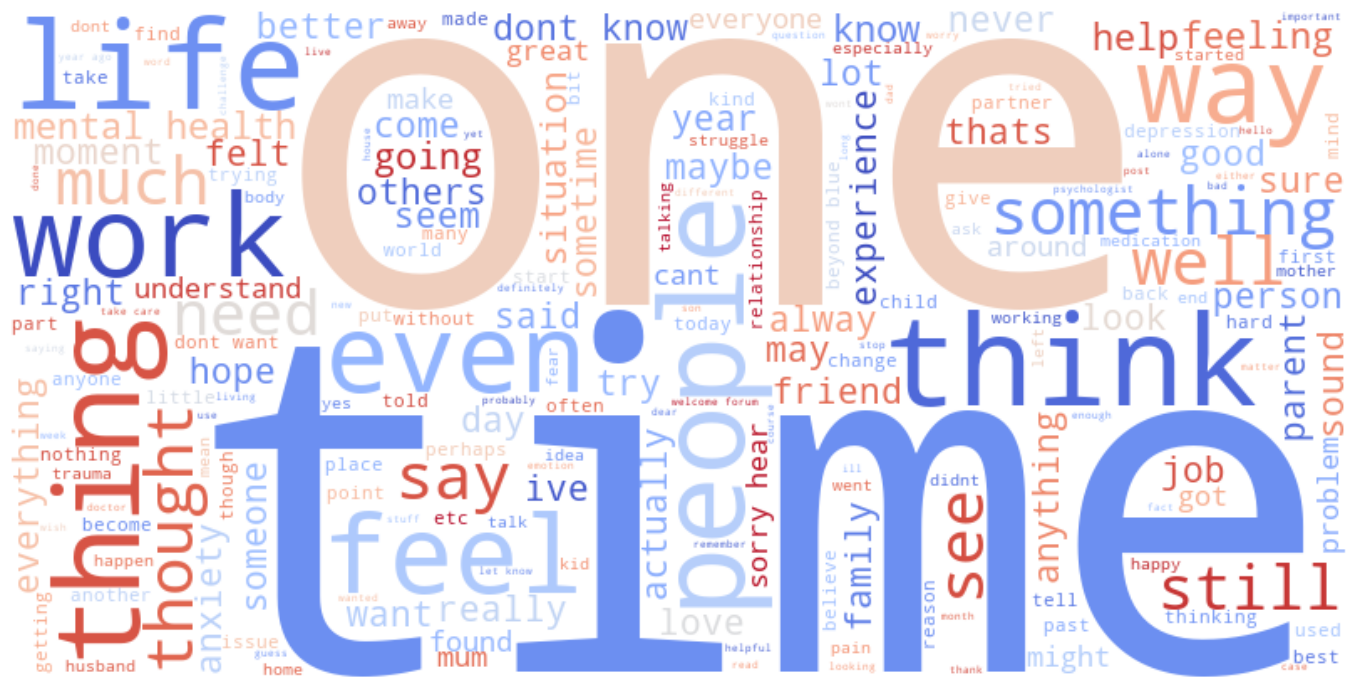

In [36]:
from wordcloud import WordCloud

# Combine all clean_text from train_df into a single string
all_text = " ".join(train_df['clean_text'].dropna())

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200, colormap='coolwarm').generate(all_text)

# Plot the word cloud
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.show()

### 2.2 Extract LIWC-style features (via Empath)
Interpretable, lexicon-based emotional dimensions. We will apply to the training dataset to compare which feature extraction has the higher impact.

In [37]:
# ! pip install empath
from empath import Empath
lexicon = Empath()

# Apply Empath to each cleaned post
empath_out = train_df[["user_id", "post_id", "comment_id", "is_post", "timestamp", "category", "clean_text"]].copy()
empath_out['liwc_empath'] = empath_out['clean_text'].apply(lambda x: lexicon.analyze(x, normalize=True))

print(empath_out['liwc_empath'].head())

12504    {'help': 0.0, 'office': 0.0, 'dance': 0.0, 'mo...
12957    {'help': 0.01694915254237288, 'office': 0.0, '...
36996    {'help': 0.020134228187919462, 'office': 0.006...
8646     {'help': 0.1111111111111111, 'office': 0.01851...
20827    {'help': 0.025, 'office': 0.0, 'dance': 0.0, '...
Name: liwc_empath, dtype: object


In [38]:
empath_out['liwc_empath'].iloc[1]

{'help': 0.01694915254237288,
 'office': 0.0,
 'dance': 0.00847457627118644,
 'money': 0.0,
 'wedding': 0.00847457627118644,
 'domestic_work': 0.0,
 'sleep': 0.00847457627118644,
 'medical_emergency': 0.0,
 'cold': 0.0,
 'hate': 0.025423728813559324,
 'cheerfulness': 0.0,
 'aggression': 0.0,
 'occupation': 0.0,
 'envy': 0.0,
 'anticipation': 0.0,
 'family': 0.00847457627118644,
 'vacation': 0.0,
 'crime': 0.0,
 'attractive': 0.00847457627118644,
 'masculine': 0.0,
 'prison': 0.0,
 'health': 0.0,
 'pride': 0.0,
 'dispute': 0.0,
 'nervousness': 0.01694915254237288,
 'government': 0.0,
 'weakness': 0.0,
 'horror': 0.0,
 'swearing_terms': 0.00847457627118644,
 'leisure': 0.01694915254237288,
 'suffering': 0.03389830508474576,
 'royalty': 0.0,
 'wealthy': 0.0,
 'tourism': 0.0,
 'furniture': 0.00847457627118644,
 'school': 0.0,
 'magic': 0.0,
 'beach': 0.0,
 'journalism': 0.0,
 'morning': 0.0,
 'banking': 0.0,
 'social_media': 0.0,
 'exercise': 0.0,
 'night': 0.0,
 'kill': 0.0,
 'blue_collar

In [39]:
empath_out['liwc_empath'].apply(type).value_counts()

liwc_empath
<class 'dict'>    27119
Name: count, dtype: int64

In [40]:
empath_out['liwc_empath'].apply(lambda x: isinstance(x, dict) and len(x) == 0).sum()

0

In [41]:
empath_out.head()

user_id  post_id comment_id  is_post  timestamp  \
12504     1100       60          4    False 2022-04-04   
12957     1115     6068         27    False 2020-07-03   
36996     5311     4906          0     True 2020-05-06   
8646      1045     5976          1    False 2022-04-24   
20827     1538     4551          6    False 2021-05-09   

                              category  \
12504                          Anxiety   
12957  Suicidal thoughts and self-harm   
36996                  PTSD and trauma   
8646   Suicidal thoughts and self-harm   
20827                  PTSD and trauma   

                                              clean_text  \
12504  thank much everyone first time using forum whi...   
12957  hello bbydoll hard find thing enjoy painim sor...   
36996  ptsd triggered several month ago consequence a...   
8646   dear nonstampcollectorfan post sound like diff...   
20827  rarepixy multiple mental illness found working...   

                                             liwc_empath  
12504  {'help': 0.0, 'office': 0.0, 'dance': 0.0, 'mo...  
12957  {'help': 0.01694915254237288, 'office': 0.0, '...  
36996  {'help': 0.020134228187919462, 'office': 0.006...  
8646   {'help': 0.1111111111111111, 'office': 0.01851...  
20827  {'help': 0.025, 'office': 0.0, 'dance': 0.0, '...

In [42]:
empath_out.isna().sum()

user_id        0
post_id        0
comment_id     0
is_post        0
timestamp      0
category       0
clean_text     0
liwc_empath    0
dtype: int64

In [43]:
empath_out.shape

(27119, 8)

In [44]:
from pandas import json_normalize

empath_norm = json_normalize(empath_out['liwc_empath']).reset_index(drop=True)
empath_norm.columns = [f"empath_{col}" for col in empath_norm.columns]

empath_out = empath_out.drop(columns=['liwc_empath']).reset_index(drop=True)

empath_out = pd.concat([empath_out, empath_norm], axis=1)


In [45]:
empath_out.isna().sum()

user_id                    0
post_id                    0
comment_id                 0
is_post                    0
timestamp                  0
                          ..
empath_contentment         0
empath_writing             0
empath_rural               0
empath_positive_emotion    0
empath_musical             0
Length: 201, dtype: int64

In [46]:
empath_out.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27119 entries, 0 to 27118
Columns: 201 entries, user_id to empath_musical
dtypes: bool(1), datetime64[ns](1), float64(194), int64(2), object(3)
memory usage: 41.4+ MB


In [47]:
empath_out = pd.concat([empath_out], axis=1)
empath_out.to_csv("empath_train.csv", index=False)

Here we save empath features to csv, we will use it for the future work.

In [48]:
empath_train = pd.read_csv("empath_train.csv")
empath_train.head()

user_id  post_id  comment_id  is_post   timestamp  \
0     1100       60           4    False  2022-04-04   
1     1115     6068          27    False  2020-07-03   
2     5311     4906           0     True  2020-05-06   
3     1045     5976           1    False  2022-04-24   
4     1538     4551           6    False  2021-05-09   

                          category  \
0                          Anxiety   
1  Suicidal thoughts and self-harm   
2                  PTSD and trauma   
3  Suicidal thoughts and self-harm   
4                  PTSD and trauma   

                                          clean_text  empath_help  \
0  thank much everyone first time using forum whi...     0.000000   
1  hello bbydoll hard find thing enjoy painim sor...     0.016949   
2  ptsd triggered several month ago consequence a...     0.020134   
3  dear nonstampcollectorfan post sound like diff...     0.111111   
4  rarepixy multiple mental illness found working...     0.025000   

   empath_office  empath_dance  ...  empath_weapon  empath_children  \
0       0.000000      0.000000  ...       0.000000         0.000000   
1       0.000000      0.008475  ...       0.000000         0.025424   
2       0.006711      0.000000  ...       0.006711         0.020134   
3       0.018519      0.000000  ...       0.000000         0.000000   
4       0.000000      0.000000  ...       0.000000         0.025000   

   empath_monster  empath_ocean  empath_giving  empath_contentment  \
0             0.0           0.0       0.066667            0.066667   
1             0.0           0.0       0.016949            0.016949   
2             0.0           0.0       0.020134            0.033557   
3             0.0           0.0       0.055556            0.000000   
4             0.0           0.0       0.000000            0.000000   

   empath_writing  empath_rural  empath_positive_emotion  empath_musical  
0        0.000000           0.0                 0.066667        0.000000  
1        0.000000           0.0                 0.093220        0.016949  
2        0.006711           0.0                 0.026846        0.000000  
3        0.000000           0.0                 0.037037        0.000000  
4        0.000000           0.0                 0.050000        0.000000  

[5 rows x 201 columns]

In [49]:
# Select only empath columns
empath_cols = [col for col in empath_train.columns if col.startswith('empath_')]
top_empath = empath_train[empath_cols].mean().sort_values(ascending=False).head(10)
print(top_empath)

empath_positive_emotion    0.039635
empath_negative_emotion    0.032395
empath_speaking            0.030808
empath_nervousness         0.029930
empath_health              0.029603
empath_communication       0.029214
empath_pain                0.028925
empath_shame               0.027073
empath_optimism            0.026554
empath_sadness             0.024616
dtype: float64


In [50]:
empath_train.shape

(27119, 201)

<Axes: title={'center': 'Top 10 Empath Categories'}>

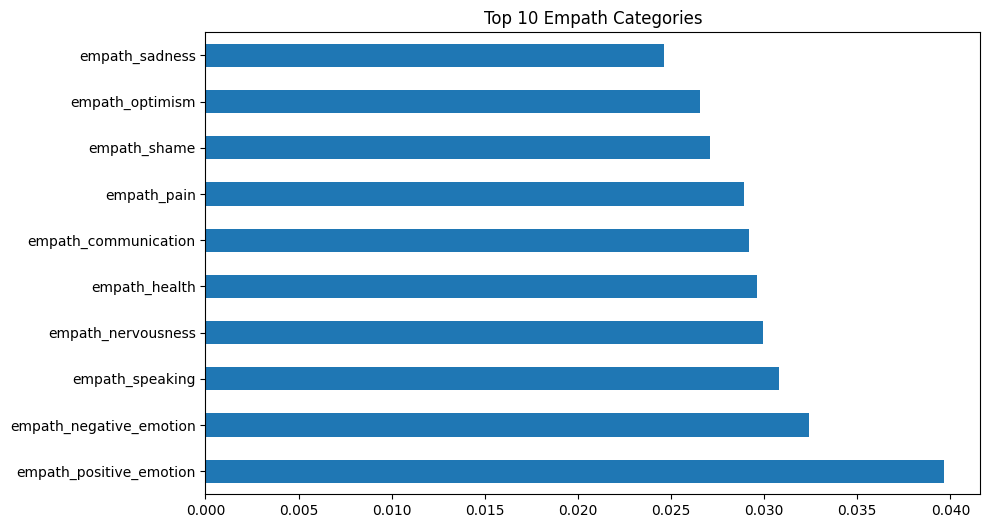

In [51]:
top_empath.plot(kind='barh', figsize=(10,6), title="Top 10 Empath Categories")

<Axes: title={'center': 'Top Empath Emotions Over Time'}, xlabel='date'>

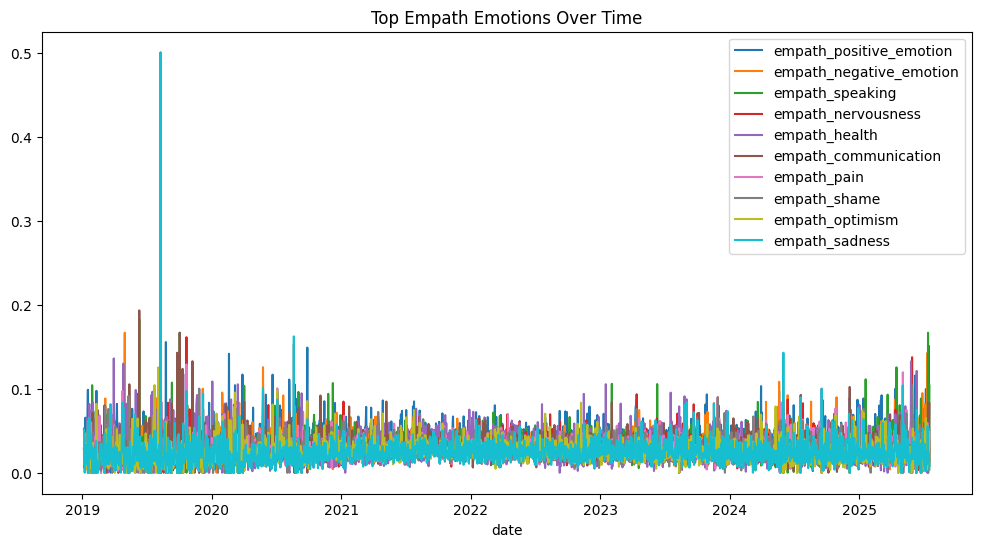

In [52]:
empath_train['date'] = pd.to_datetime(empath_train['timestamp']).dt.date
daily_emotions = empath_train.groupby('date')[top_empath.index].mean()

daily_emotions.plot(figsize=(12,6), title="Top Empath Emotions Over Time")

<Axes: title={'center': 'Smoothed Empath Emotions Over Time'}, xlabel='date'>

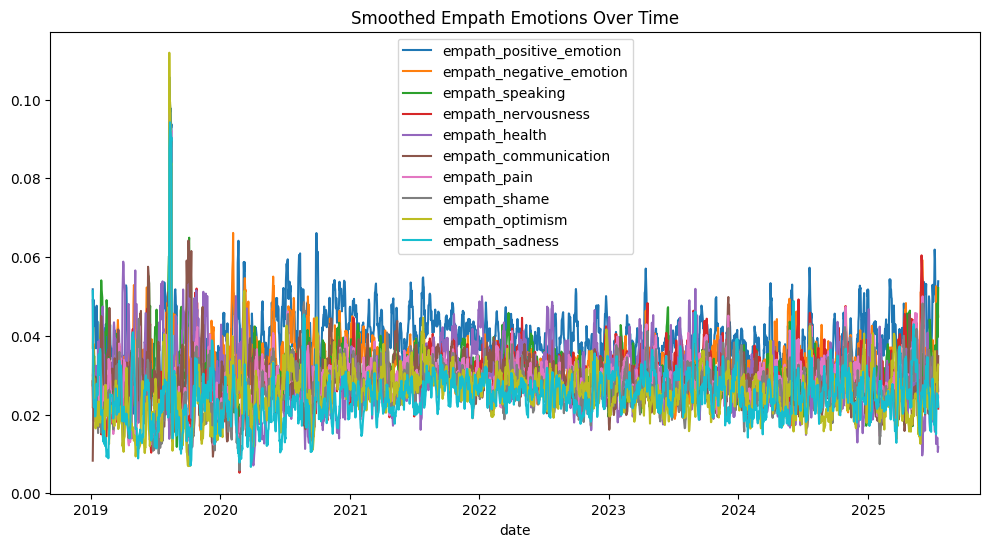

In [53]:
smoothed = daily_emotions.rolling(window=7, min_periods=1).mean()
smoothed.plot(figsize=(12,6), title="Smoothed Empath Emotions Over Time")

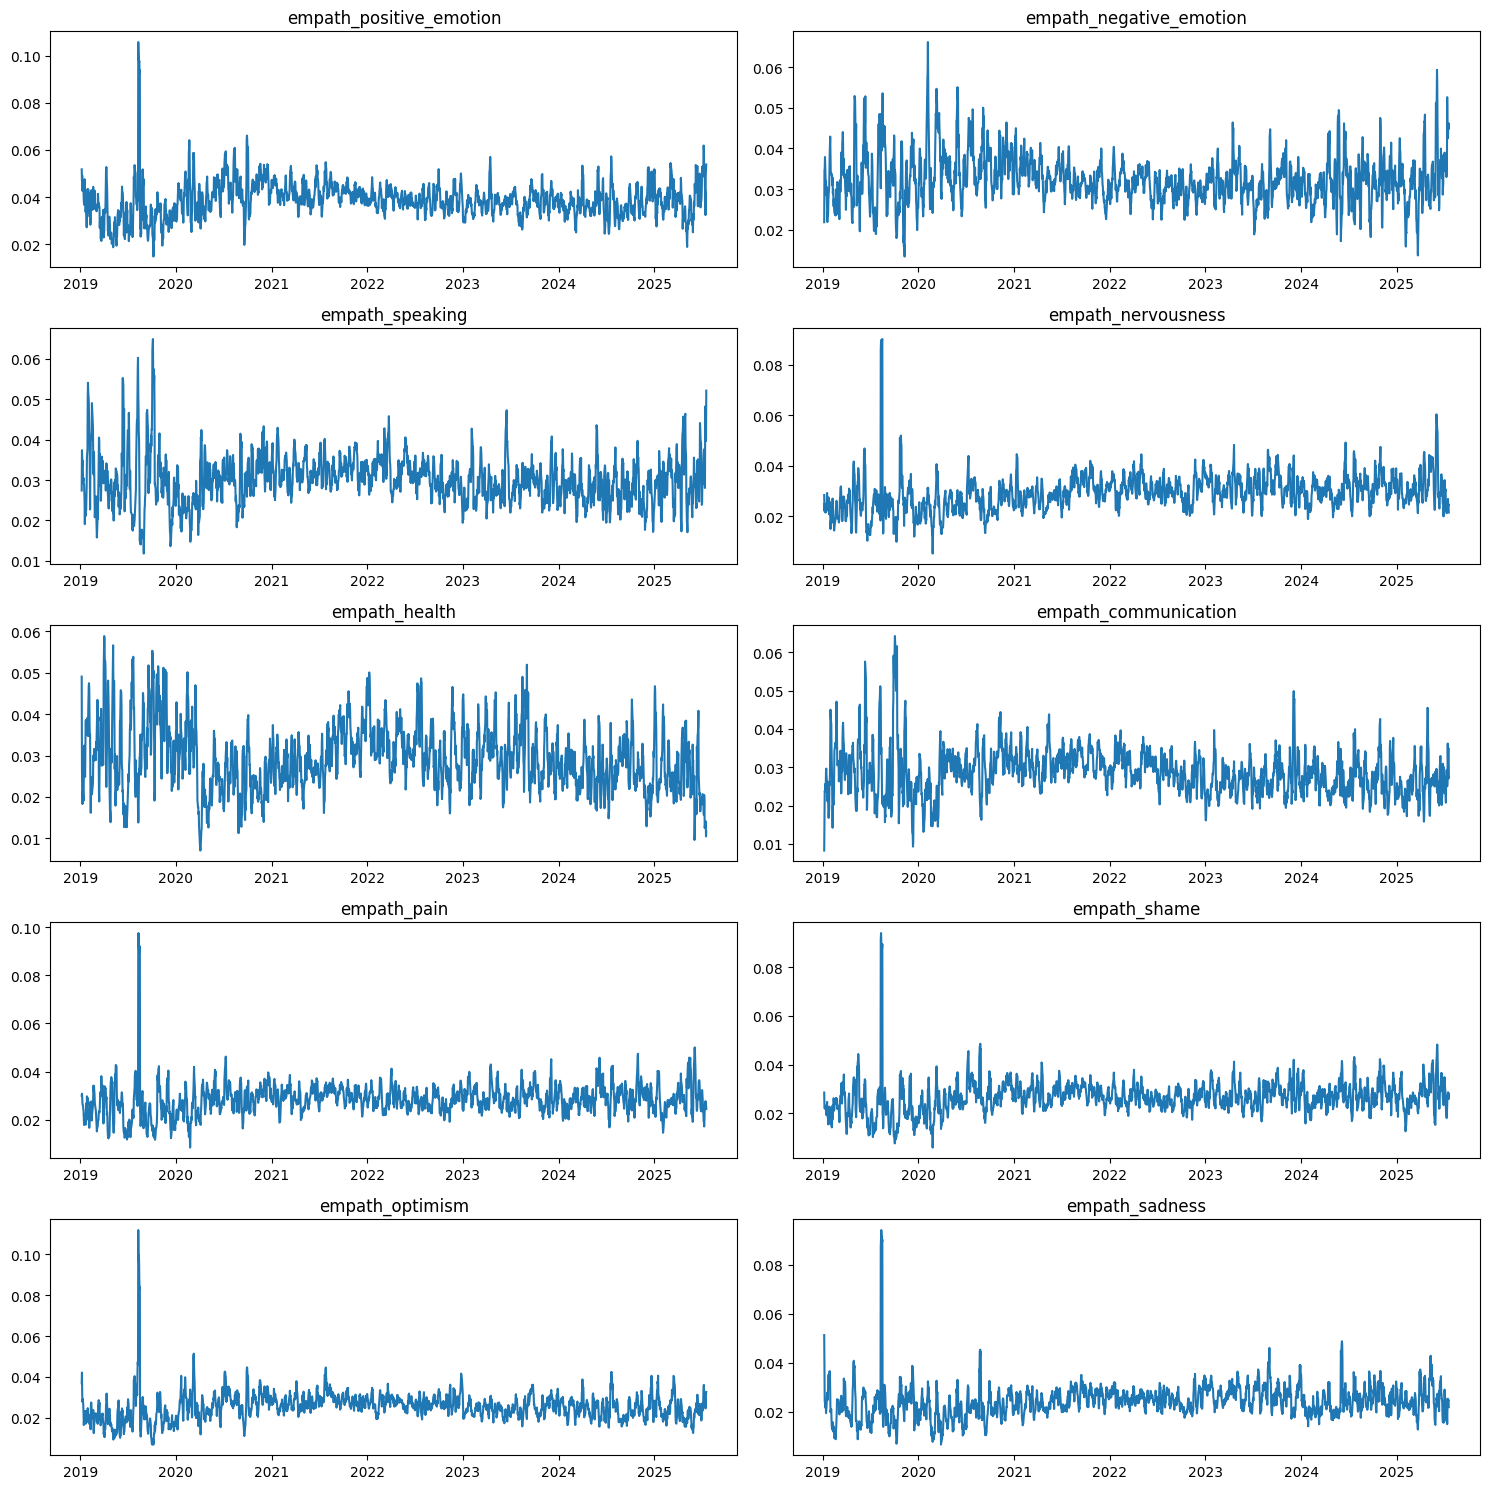

In [54]:
fig, axs = plt.subplots(5, 2, figsize=(15, 15))
axs = axs.flatten()

for i, col in enumerate(top_empath.index):
    axs[i].plot(smoothed[col])
    axs[i].set_title(col)

plt.tight_layout()

We can see that Empath features simulates LIWC output and provides psychological signals extracted from the post. It numerically summarizes the content in terms of emotion, behavior, and social context.

### 2.3 DLATK 1,2-gram Feature Extraction
Surface-level linguistic patterns

In [55]:
from sqlalchemy import create_engine
from sqlalchemy import Integer, Text, DateTime
import getpass

export_train = train_df[['user_id', 'timestamp', 'clean_text']].copy()
export_train.columns = ['user_id', 'datetime', 'message']
export_train['message_id'] = export_train.index

username = 'root'
password = getpass.getpass("Enter MySQL password: ")
database = 'dla_db'
host = 'localhost'

engine = create_engine(f"mysql+pymysql://{username}:{password}@{host}/{database}")
export_train.to_sql(
    'beyond_blue_msgs',
    engine,
    if_exists='replace',
    index=False,
    dtype={
        'user_id': Integer(),
        'message': Text(),
        'datetime': DateTime(),
        'message_id': Integer()
    }
)

27119

Due to DLATK only accept the data from My SQL,we use DLATK to get ngrams from here.

python dlatkInterface.py \
  -d dla_db \
  -t beyond_blue_msgs \
  -c user_id \
  --message_field message \
  --messageid_field message_id \
  --date_field datetime

python dlatkInterface.py \
  -d dla_db \
  -t beyond_blue_msgs \
  -c user_id \
  --message_field message \
  --messageid_field message_id \
  --date_field datetime \
  --add_ngrams

  python dlatkInterface.py \
  -d dla_db \
  -t beyond_blue_msgs \
  -c user_id \
  -f 'feat$1gram$beyond_blue_msgs$user_id' \
  --print_csv train_1gram.csv


In [56]:
train_1gram = pd.read_csv("./train_1gram.csv")

In [57]:
print(train_1gram.describe())
print(train_1gram.info())

          group_id        aaaand        aaac      aaaghh  aaannnd  \
count   469.000000  4.690000e+02  469.000000  469.000000    469.0   
mean   3380.562900  5.391141e-07    0.000006    0.000002      0.0   
std    1822.442741  1.167527e-05    0.000123    0.000048      0.0   
min    1006.000000  0.000000e+00    0.000000    0.000000      0.0   
25%    1802.000000  0.000000e+00    0.000000    0.000000      0.0   
50%    2947.000000  0.000000e+00    0.000000    0.000000      0.0   
75%    4894.000000  0.000000e+00    0.000000    0.000000      0.0   
max    7297.000000  2.528445e-04    0.002663    0.001031      0.0   

              aagod    aah    aan   aand  aanother  ...          zoot  \
count  4.690000e+02  469.0  469.0  469.0     469.0  ...  4.690000e+02   
mean   2.619727e-07    0.0    0.0    0.0       0.0  ...  1.977900e-08   
std    5.673389e-06    0.0    0.0    0.0       0.0  ...  4.283421e-07   
min    0.000000e+00    0.0    0.0    0.0       0.0  ...  0.000000e+00   
25%    0.0000

In [58]:
train_1gram.rename(columns={'group_id': 'user_id'}, inplace=True)

# Drop n-grams used by less than 1% of users
min_user_count = int(len(train_1gram) * 0.01)
train_1gram = train_1gram.loc[:, (train_1gram != 0).sum(axis=0) > min_user_count]

In [59]:
train_1gram.head()

user_id  aaron  aaronsis  abandon  abandoned  abandoning  abandonment  \
0     2059    0.0       0.0      0.0        0.0         0.0          0.0   
1     2069    0.0       0.0      0.0        0.0         0.0          0.0   
2     4119    0.0       0.0      0.0        0.0         0.0          0.0   
3     2072    0.0       0.0      0.0        0.0         0.0          0.0   
4     6170    0.0       0.0      0.0        0.0         0.0          0.0   

        abc  abide   ability  ...  yummy  zazu  zealand  zero  zest  zombie  \
0  0.000000    0.0  0.000000  ...    0.0   0.0      0.0   0.0   0.0     0.0   
1  0.000000    0.0  0.000786  ...    0.0   0.0      0.0   0.0   0.0     0.0   
2  0.000000    0.0  0.000000  ...    0.0   0.0      0.0   0.0   0.0     0.0   
3  0.000000    0.0  0.000000  ...    0.0   0.0      0.0   0.0   0.0     0.0   
4  0.001969    0.0  0.000984  ...    0.0   0.0      0.0   0.0   0.0     0.0   

   zone  zoning  zoo  zoom  
0   0.0     0.0  0.0   0.0  
1   0.0     0.0  0.0   0.0  
2   0.0     0.0  0.0   0.0  
3   0.0     0.0  0.0   0.0  
4   0.0     0.0  0.0   0.0  

[5 rows x 8962 columns]

In [60]:
train_1gram.shape

(469, 8962)

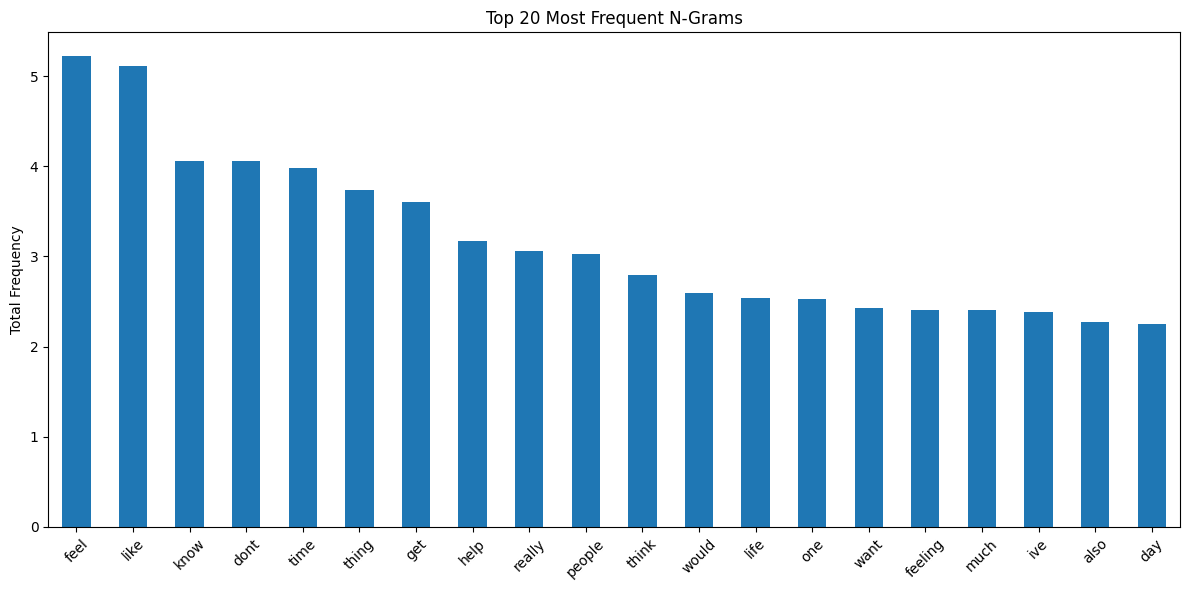

In [61]:
ngram_totals = train_1gram.drop(columns=['user_id']).sum().sort_values(ascending=False)

# Plot top 20
top_20 = ngram_totals.head(20)
plt.figure(figsize=(12, 6))
top_20.plot(kind='bar')
plt.title('Top 20 Most Frequent N-Grams')
plt.ylabel('Total Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

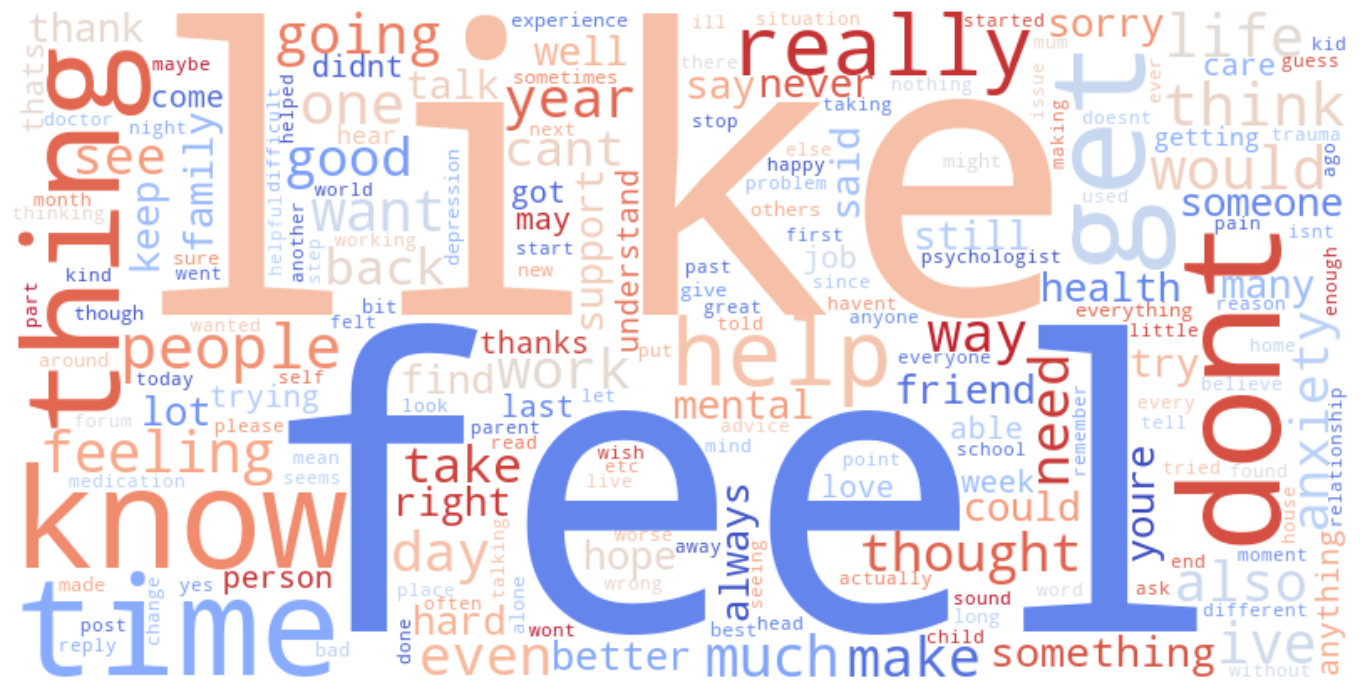

In [62]:
from wordcloud import WordCloud

# Drop the user_id column and sum over users to get global frequency
ngram_freq = train_1gram.drop(columns=['user_id']).sum().to_dict()

# Optionally filter out ngrams with zero frequency
ngram_freq = {k: v for k, v in ngram_freq.items() if v > 0}

wordcloud = WordCloud(width=800, height=400, background_color='white',
                      max_words=200, colormap='coolwarm').generate_from_frequencies(ngram_freq)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.show()

DLATK 1-gram only shows the frequency that the words show up. So the result looks not related to what we need, let's do it again with stopwords. First, we will refer emotion wheel to select the emotion words manually. Second, we will use NRCLex to be the comparison.

In [63]:
emotion_words = [
    # Anger
    "agitated", "frustrated", "annoyed", "aggravated", "hostile", "dread", "hate",
    "irritable", "exasperated", "rage", "envy", "jealous", "resentful",
    "contempt", "revolted", "agony",
    
    # Fear
    "anxious", "worried", "inadequate", "hysterical", "panic", "helpless",
    "frightened", "scared", "terror", "nervous", "insecure", "horror",
    
    # Sadness
    "disappointed", "shameful", "neglected", "despair", "guilty", "isolated",
    "lonely", "grief", "powerless", "depressed", "sorrow", "dismayed",
    "displeased", "regretful", "hurt",
    
    # Surprise
    "stunned", "confused", "amazed", "overcome", "moved", "content",
    "delighted", "amused", "pleased", "satisfied", "stimulated", "touched",
    "speechless", "astonished", "awe-struck", "perplexed", "disillusioned", "disoriented",
    
    # Love
    "compassionate", "caring", "affectionate", "desire", "longing", "infatuation",
    "passion", "attracted", "sentimental", "fondness", "romantic", "rapture",
    "enchanted", "jubilant", "euphoric",
    
    # Joy
    "cheerful", "happy", "proud", "excited", "hopeful", "eager",
    "enthralled", "elated", "enthusiastic", "zeal", "optimistic", "blissful",
    "triumphant", "jovial", "delighted", "satisfied", "joyful", "content",
    "illustrious", "enchanted"
]

# Reference https://www.davidhodder.com/emotion-and-feeling-wheel/

filtered_cols = [col for col in train_1gram.columns if any(word in col for word in emotion_words)]
filtered_train_1gram = train_1gram[['user_id'] + filtered_cols]  # Keep ID column too

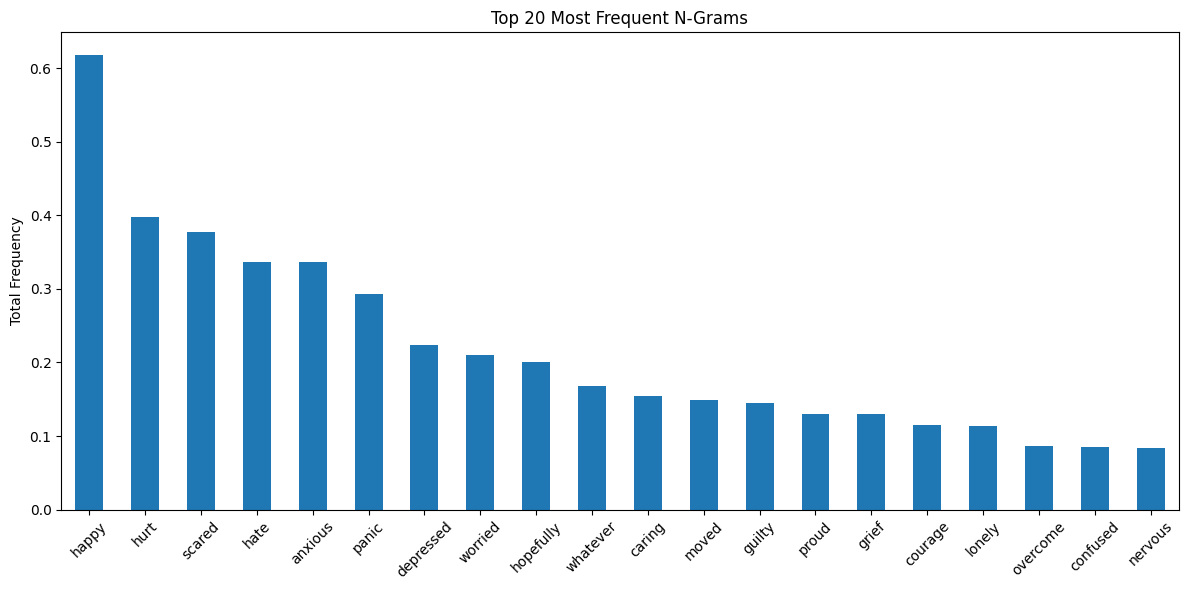

In [64]:
ngram_total = filtered_train_1gram.drop(columns=['user_id']).sum().sort_values(ascending=False)

# Plot top 20
top_20 = ngram_total.head(20)
plt.figure(figsize=(12, 6))
top_20.plot(kind='bar')
plt.title('Top 20 Most Frequent N-Grams')
plt.ylabel('Total Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

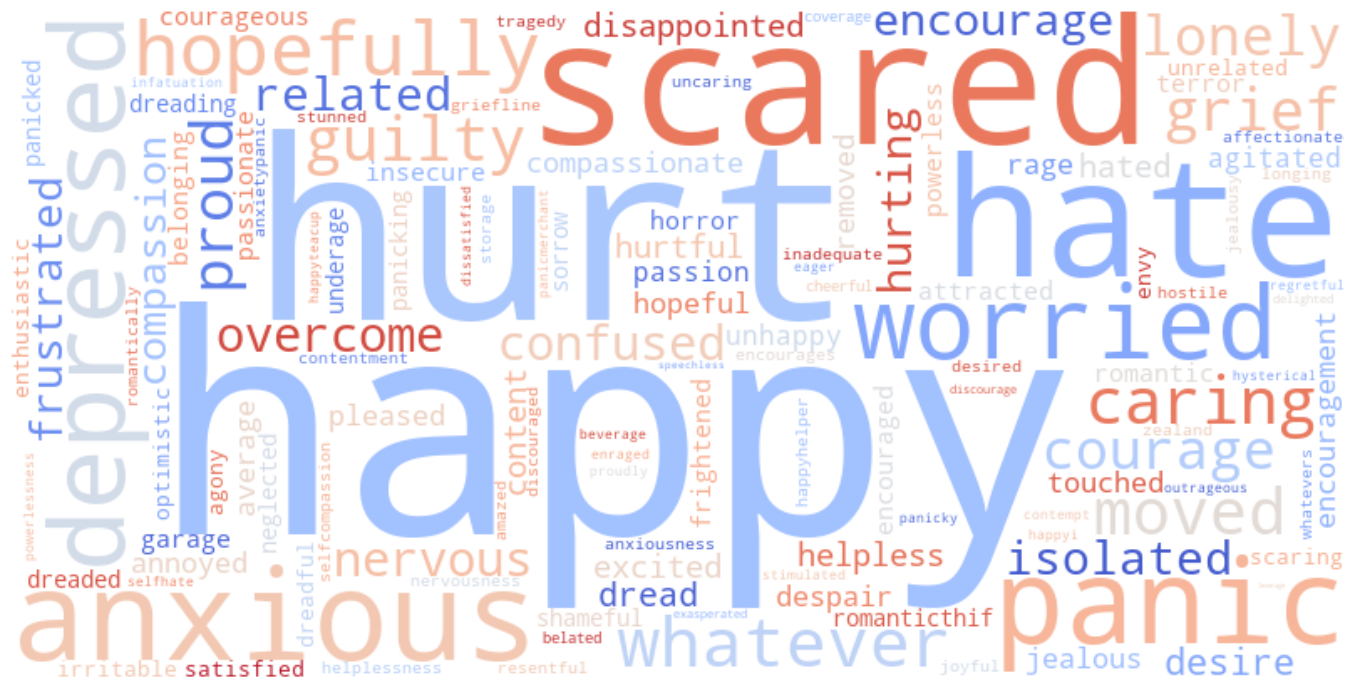

In [65]:
from wordcloud import WordCloud

# Drop the user_id column and sum over users to get global frequency
ngram_total = filtered_train_1gram.drop(columns=['user_id']).sum().to_dict()

# Optionally filter out ngrams with zero frequency
ngram_total = {k: v for k, v in ngram_total.items() if v > 0}

wordcloud = WordCloud(width=800, height=400, background_color='white',
                      max_words=200, colormap='coolwarm').generate_from_frequencies(ngram_total)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.show()

### 2.4 NRCLex Feature Extraction

In [66]:
# Reference https://pypi.org/project/NRCLex/
from nrclex import NRCLex
from tqdm import tqdm

def nrc_emo(text):
    emotion = NRCLex(text)
    return emotion.raw_emotion_scores

tqdm.pandas()

In [67]:
nrc_train = train_df[["user_id", "post_id", "comment_id", "is_post", "timestamp", "category", "clean_text"]].copy()

nrc_train['nrc_emotion'] = nrc_train['clean_text'].progress_apply(nrc_emo)

100%|██████████| 27119/27119 [00:07<00:00, 3735.71it/s]


In [72]:
nrc_train.head()

user_id  post_id comment_id  is_post  timestamp  \
12504     1100       60          4    False 2022-04-04   
12957     1115     6068         27    False 2020-07-03   
36996     5311     4906          0     True 2020-05-06   
8646      1045     5976          1    False 2022-04-24   
20827     1538     4551          6    False 2021-05-09   

                              category  \
12504                          Anxiety   
12957  Suicidal thoughts and self-harm   
36996                  PTSD and trauma   
8646   Suicidal thoughts and self-harm   
20827                  PTSD and trauma   

                                              clean_text  \
12504  thank much everyone first time using forum whi...   
12957  hello bbydoll hard find thing enjoy painim sor...   
36996  ptsd triggered several month ago consequence a...   
8646   dear nonstampcollectorfan post sound like diff...   
20827  rarepixy multiple mental illness found working...   

                                             nrc_emotion  
12504  {'anticipation': 3, 'fear': 2, 'negative': 2, ...  
12957  {'anticipation': 10, 'joy': 14, 'positive': 19...  
36996  {'anger': 11, 'anticipation': 14, 'fear': 12, ...  
8646   {'positive': 11, 'fear': 4, 'joy': 5, 'trust':...  
20827  {'fear': 3, 'negative': 7, 'sadness': 4, 'joy'...

In [69]:
nrc_train['nrc_emotion'].iloc[1]

{'anticipation': 10,
 'joy': 14,
 'positive': 19,
 'trust': 12,
 'anger': 7,
 'fear': 7,
 'negative': 7,
 'sadness': 8,
 'disgust': 5,
 'surprise': 5}

In [70]:
nrc_train['nrc_emotion'].apply(type).value_counts()

nrc_emotion
<class 'dict'>    27119
Name: count, dtype: int64

In [71]:
nrc_train['nrc_emotion'].apply(lambda x: isinstance(x, dict) and len(x) == 0).sum()

619

In [73]:
nrc_expanded = nrc_train['nrc_emotion'].apply(pd.Series).fillna(0).astype(int)
nrc_train = pd.concat([nrc_train, nrc_expanded], axis=1)

In [74]:
nrc_train.isna().sum()

user_id         0
post_id         0
comment_id      0
is_post         0
timestamp       0
category        0
clean_text      0
nrc_emotion     0
anticipation    0
fear            0
negative        0
anger           0
disgust         0
joy             0
positive        0
sadness         0
surprise        0
trust           0
dtype: int64

In [76]:
# Select only NRC numeric columns (not the 'nrc_emotion' dict column)
nrc_numeric_cols = ['anticipation', 'fear', 'negative', 'anger', 'disgust', 'joy', 'positive', 'sadness', 'surprise', 'trust']
top_nrc = nrc_train[nrc_numeric_cols].mean().sort_values(ascending=False).head(10)
print(top_nrc)

positive        10.078211
negative         7.127291
trust            6.303920
anticipation     5.826764
sadness          4.716251
fear             4.708581
joy              4.586120
anger            3.400199
surprise         2.376599
disgust          2.191747
dtype: float64


<Axes: title={'center': 'NRC Categories'}>

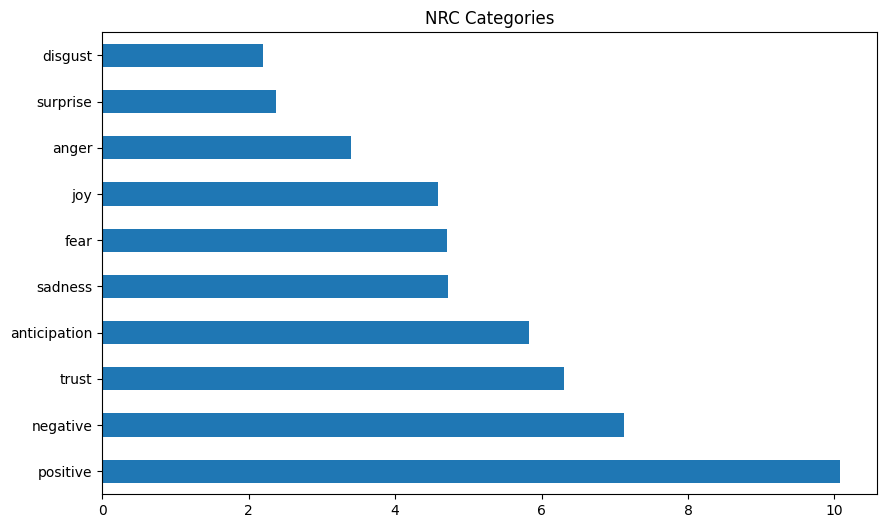

In [78]:
top_nrc.plot(kind='barh', figsize=(10,6), title="NRC Categories")

<Axes: title={'center': 'Top NRC Emotions Over Time'}, xlabel='date'>

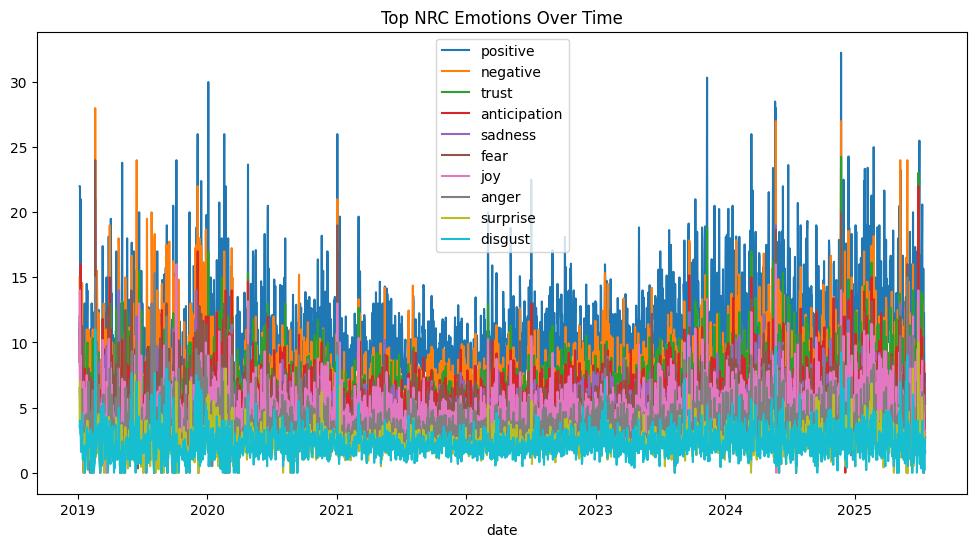

In [79]:
nrc_train['date'] = pd.to_datetime(nrc_train['timestamp']).dt.date
daily_emotions = nrc_train.groupby('date')[top_nrc.index].mean()

daily_emotions.plot(figsize=(12,6), title="Top NRC Emotions Over Time")

### 2.5  Train LDA using Gensim
Hidden semantic/emotional structures


In [ ]:
texts = df_export['message'].dropna().tolist()

In [ ]:
# !pip install gensim

In [ ]:
from gensim import corpora, models
from nltk.tokenize import word_tokenize

def preprocess(text):
    return [word.lower() for word in word_tokenize(text) if word.isalpha() and word.lower() not in stop_words]

tokenized_texts = [preprocess(text) for text in texts]

dictionary = corpora.Dictionary(tokenized_texts)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

# Train LDA model
lda_model = models.LdaModel(corpus, num_topics=100, id2word=dictionary, passes=10)


Here we train LDA with 100 topics first, later we will use CoherenceModel to find the best number of topics and retrain LDA

In [ ]:
# from gensim.models import CoherenceModel
# from tqdm import tqdm

# # Define a range of topic numbers to test
# topic_nums = [20, 30, 50, 70, 100]
# coherence_scores = []

# for num in tqdm(topic_nums):
#     lda = models.LdaModel(corpus=corpus,
#                           id2word=dictionary,
#                           num_topics=num,
#                           random_state=42,
#                           passes=10,
#                           chunksize=100,
#                           per_word_topics=True)
    
#     coherence_model = CoherenceModel(model=lda, texts=df['clean_text'].str.split(), dictionary=dictionary, coherence='c_v')
#     coherence = coherence_model.get_coherence()
#     coherence_scores.append(coherence)
#     print(f"Topics: {num} → Coherence: {coherence:.4f}")

# # Plotting
# plt.figure(figsize=(10, 5))
# plt.plot(topic_nums, coherence_scores, marker='o')
# plt.title("LDA Coherence Score by Number of Topics")
# plt.xlabel("Number of Topics")
# plt.ylabel("Coherence Score (c_v)")
# plt.grid(True)
# plt.show()

From the plot we can see that 30 topics is the best number for our dataset, we will train again with 30 topics.

In [ ]:
final_lda_model = models.LdaModel(
    corpus=corpus,
    num_topics=30,
    id2word=dictionary,
    passes=10,
    random_state=42
)

In [ ]:
import pickle

pickle.dump(final_lda_model, open("lda_model.pkl", "wb"))
pickle.dump(corpus, open("corpus.pkl", "wb"))
pickle.dump(dictionary, open("dictionary.pkl", "wb"))

In [ ]:
message_ids = df_export.index.tolist()
user_ids = df_export['user_id'].tolist()

lda_vectors = []
for bow in corpus:
    topic_probs = final_lda_model.get_document_topics(bow, minimum_probability=0)
    vector = [prob for _, prob in sorted(topic_probs, key=lambda x: x[0])]
    lda_vectors.append(vector)

In [ ]:
topic_cols = [f"topic_{i}" for i in range(30)]
df_lda_msgs = pd.DataFrame(lda_vectors, columns=topic_cols)
df_lda_msgs["user_id"] = user_ids

In [ ]:
df_lda_msgs.head(5)

In [ ]:
df_lda_msgs.to_csv("lda30.csv", index=False)

In [ ]:
df_lda = pd.read_csv("lda30.csv")

In [ ]:
print(df_lda.describe())
print(df_lda.info())

In [ ]:
df_lda.head()

In [ ]:
df_lda_user = df_lda.groupby('user_id').mean().reset_index()

In [ ]:
print(df['user_id'].nunique(), df.shape[0])
print(df_lda_user['user_id'].nunique(), df_lda_user.shape[0])

In [ ]:
for i in range(30):  # Show top 5 topics
    words = final_lda_model.show_topic(i, topn=10)
    print(f"Topic {i}:")
    print(", ".join([word for word, prob in words]))
    print()

In [ ]:
for i in range(5):
    plt.figure()
    word_probs = dict(final_lda_model.show_topic(i, topn=30))
    wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_probs)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout()
    plt.show()

In [ ]:
! python visualize_lda.py

This interactive plot (pyLDAvis) shows how topics differ from one another and what words best describe each. The red bars show words that are especially representative of a selected topic, even if they aren’t the most frequent overall. This helps us better understand what each topic is really about.

### 2.5 Circumplex Model Mapping
In this part we extract each emotional category to set it as valence and arousal score.

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def create_automated_circumplex_mapping():
    """
    Automatically map any text-based category to circumplex space using sentiment analysis
    """
    analyzer = SentimentIntensityAnalyzer()
    
    def map_category_to_circumplex(category_name):
        """Map any category name to valence/arousal using sentiment analysis"""
        # Clean category name (remove underscores, etc.)
        clean_name = category_name.replace('_', ' ').replace('empath_', '')
        
        # Get sentiment scores
        scores = analyzer.polarity_scores(clean_name)
        
        # Map compound score to valence
        valence = scores['compound']
        
        # Map arousal based on intensity of emotion (positive or negative)
        # High positive or high negative = high arousal
        arousal = max(scores['pos'], scores['neg']) * 2 - 0.5  # Scale to [-0.5, 1.5] then clamp
        
        # Clamp to valid range
        valence = max(-1.0, min(1.0, valence))
        arousal = max(-1.0, min(1.0, arousal))
        
        return valence, arousal
    
    return map_category_to_circumplex

In [ ]:
def apply_universal_circumplex_mapping(method='sentiment'):
    """
    Apply the same mapping approach to all three feature types
    """
    # Choose mapping method
    if method == 'sentiment':
        mapper = create_automated_circumplex_mapping()
    else:
        raise ValueError("Method must be 'sentiment'")

    print(f"Using {method} method for circumplex mapping")
    print("="*50)

#### 2.5.1 Apply Empath to Circumplex Model

In [ ]:
# 1. EMPATH PROCESSING
print("1. Processing Empath features...")
df_empath_user = df_empath.groupby('user_id').agg({
    col: 'mean' for col in df_empath.columns if col.startswith('empath_')
}).reset_index()
    
def map_empath_user_to_circumplex(row):
    total_valence = 0.0
    total_arousal = 0.0
    total_weight = 0.0
        
    for col, score in row.items():
        if col.startswith('empath_') and score > 0:
            category = col.replace('empath_', '')
            valence, arousal = mapper(category)
                
            weight = score
            total_valence += valence * weight
            total_arousal += arousal * weight
            total_weight += weight
        
    if total_weight > 0:
        final_valence = total_valence / total_weight
        final_arousal = total_arousal / total_weight
    else:
        final_valence = 0.0
        final_arousal = 0.0
            
    return pd.Series({'empath_valence': final_valence, 'empath_arousal': final_arousal})
    
df_empath_circumplex = df_empath_user.copy()
df_empath_circumplex[['empath_valence', 'empath_arousal']] = df_empath_user.apply(map_empath_user_to_circumplex, axis=1)

In [ ]:
# By copilot
def map_to_circumplex(empath_dict):
    """
    Map Empath emotional categories to valence and arousal dimensions
    using the Circumplex Model of Emotion.
    """
    
    # Define emotional categories and their circumplex coordinates
    # Valence: -1 (negative) to +1 (positive)
    # Arousal: -1 (calm) to +1 (activated)
    
    empath_mapping = {
        # High Positive Valence, High Arousal
        'joy': (0.8, 0.7), 'excitement': (0.9, 0.8), 'surprise': (0.1, 0.8),
        'anticipation': (0.4, 0.6), 'optimism': (0.7, 0.4),
        
        # High Positive Valence, Low Arousal  
        'contentment': (0.6, -0.2), 'pleasure': (0.8, 0.2), 'love': (0.9, 0.3),
        'trust': (0.5, -0.1), 'warmth': (0.7, -0.3),
        
        # Low Negative Valence, Low Arousal
        'sadness': (-0.7, -0.4), 'depression': (-0.8, -0.6), 'melancholy': (-0.6, -0.5),
        'disappointment': (-0.5, -0.3), 'boredom': (-0.2, -0.7),
        
        # High Negative Valence, High Arousal
        'anger': (-0.6, 0.8), 'fear': (-0.8, 0.7), 'anxiety': (-0.7, 0.6),
        'rage': (-0.9, 0.9), 'panic': (-0.8, 0.9), 'frustration': (-0.6, 0.7),
        'irritability': (-0.4, 0.5), 'nervousness': (-0.5, 0.6),
        
        # Neutral/Mixed emotions
        'confusion': (-0.1, 0.3), 'ambivalence': (0.0, 0.2),
        
        # Additional categories that might appear in Empath
        'positive_emotion': (0.6, 0.3), 'negative_emotion': (-0.6, 0.3),
        'emotional': (0.0, 0.5), 'feeling': (0.0, 0.2),
        'pain': (-0.7, 0.4), 'suffering': (-0.8, 0.3),
        'healing': (0.4, -0.2), 'health': (0.5, -0.1),
        'violence': (-0.8, 0.7), 'aggression': (-0.7, 0.8),
        'hate': (-0.9, 0.6), 'disgust': (-0.7, 0.4),
        'shame': (-0.6, -0.3), 'guilt': (-0.5, -0.2),
        'envy': (-0.4, 0.3), 'jealousy': (-0.5, 0.4),
        'dominant': (0.2, 0.6), 'submissive': (-0.2, -0.4),
        'confident': (0.6, 0.4), 'achievement': (0.7, 0.5),
        'power': (0.3, 0.6), 'weakness': (-0.4, -0.5),
        'strength': (0.5, 0.3), 'independence': (0.4, 0.2),
        'timidity': (-0.3, -0.4), 'pride': (0.6, 0.4)
    }
    
    total_valence = 0.0
    total_arousal = 0.0
    total_weight = 0.0
    
    for category, score in empath_dict.items():
        if score > 0 and category in empath_mapping:
            valence, arousal = empath_mapping[category]
            weight = score
            
            total_valence += valence * weight
            total_arousal += arousal * weight
            total_weight += weight
    
    # Normalize by total weight to get weighted average
    if total_weight > 0:
        final_valence = total_valence / total_weight
        final_arousal = total_arousal / total_weight
    else:
        # Default to neutral if no emotional categories found
        final_valence = 0.0
        final_arousal = 0.0
    
    # Clamp values to [-1, 1] range
    final_valence = max(-1.0, min(1.0, final_valence))
    final_arousal = max(-1.0, min(1.0, final_arousal))
    
    return final_valence, final_arousal

def map_row_to_circumplex(row):
    """Apply circumplex mapping to a DataFrame row"""
    empath_dict = {k.replace("empath_", ""): v for k, v in row.items() if k.startswith("empath_")}
    valence, arousal = map_to_circumplex(empath_dict)
    return pd.Series({'valence': valence, 'arousal': arousal})

In [ ]:
print("\n1. Processing Empath Features...")
df_empath_user = df_empath.groupby('user_id').agg({
    col: 'mean' for col in df_empath.columns if col.startswith('empath_')
}).reset_index()

df_empath_user[['empath_valence', 'empath_arousal']] = df_empath_user.apply(map_row_to_circumplex, axis=1)
print(f"Empath features processed: {df_empath_user.shape}")

In [ ]:
df_empath[['valence', 'arousal']] = df_empath.apply(map_row_to_circumplex, axis=1)
print(df_empath[['valence', 'arousal']].head())

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(df_empath['valence'], df_empath['arousal'], alpha=0.5)
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel('Valence (Negative to Positive)')
plt.ylabel('Arousal (Calm to Activated)')
plt.title('Posts in Circumplex Emotion Space')
plt.grid(True)
plt.show()


This scatterplot maps each user post onto the Circumplex Model of Emotion.
We observe that most posts fall in the slightly negative, moderately aroused region consistent with emotionally expressive yet concerned or distressed discourse.

In [ ]:
df_empath['timestamp'] = pd.to_datetime(df_empath['timestamp'], errors='coerce')
df_sorted = df_empath.sort_values('timestamp')
df_sorted[['timestamp', 'valence', 'arousal']].plot(x='timestamp', title='Emotional Shift Over Time')


This chart shows how user emotions have shifted over the past several years.
We track two emotional dimensions:

Valence, which reflects sentiment from negative to positive.

Arousal, which reflects intensity, from calm to highly activated states.
The lines fluctuate significantly, showing daily variability, but the overall range remains relatively stable, suggesting consistent emotional engagement across the years.”



In [ ]:
from sklearn.cluster import KMeans

X = df_empath[['valence', 'arousal']]
kmeans = KMeans(n_clusters=4, random_state=42).fit(X)
df_empath['emotion_cluster'] = kmeans.labels_

plt.figure(figsize=(8, 6))
plt.scatter(df_empath['valence'], df_empath['arousal'], c=df_empath['emotion_cluster'], cmap='viridis', alpha=0.5)
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel('Valence (Negative to Positive)')
plt.ylabel('Arousal (Calm to Activated)')
plt.title('Emotion Clusters in Circumplex Space')
plt.colorbar(label='Emotion Cluster')
plt.grid(True)
plt.show()

We used AI to map each forum post’s emotional tone into a 2D space of 'positivity' and 'emotional energy.' Then we grouped similar emotions together into 4 clusters using machine learning.

The result reveals that most user emotions fall into clear categories — such as energized-positive, calm-positive, low-energy negative, and intense distress. This helps us understand the emotional structure of the community over time.

In [ ]:
plt.figure(figsize=(6, 6))
plt.hist2d(df_empath['valence'], df_empath['arousal'], bins=40, cmap='viridis')
plt.colorbar(label='Post Density')
plt.xlabel('Valence')
plt.ylabel('Arousal')
plt.title('Post Density in Circumplex Space')
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.grid(True)
plt.show()

#### 2.5.2 Apply ngram to Circumplex Model

In [ ]:
# 2. N-GRAM PROCESSING  
print("2. Processing N-gram features...")
def map_ngram_user_to_circumplex(row):
    total_valence = 0.0
    total_arousal = 0.0
    total_weight = 0.0
        
    for ngram, frequency in row.items():
        if ngram != 'user_id' and frequency > 0:
            valence, arousal = mapper(ngram)
                
            weight = frequency
            total_valence += valence * weight
            total_arousal += arousal * weight
            total_weight += weight
        
    if total_weight > 0:
        final_valence = total_valence / total_weight
        final_arousal = total_arousal / total_weight
    else:
        final_valence = 0.0
        final_arousal = 0.0
            
    return pd.Series({'ngram_valence': final_valence, 'ngram_arousal': final_arousal})
    
df_ngrams_circumplex = df_ngrams.copy()
df_ngrams_circumplex[['ngram_valence', 'ngram_arousal']] = df_ngrams.apply(map_ngram_user_to_circumplex, axis=1)

In [ ]:
# Visualize n-gram circumplex results
plt.figure(figsize=(10, 6))
plt.scatter(df_ngrams['ngram_valence'], df_ngrams['ngram_arousal'], alpha=0.6)
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel('N-gram Valence')
plt.ylabel('N-gram Arousal')
plt.title('User Emotions from N-gram Patterns (VADER Sentiment)')
plt.grid(True)
plt.show()

In [ ]:
print("\nSample N-gram Sentiment Analysis:")
print("="*50)
sample_ngrams = list(ngram_sentiments.items())[:10]
for ngram, (valence, arousal) in sample_ngrams:
    print(f"'{ngram}': Valence={valence:.3f}, Arousal={arousal:.3f}")


In [ ]:
# Find most positive and negative n-grams
ngram_valences = [(ngram, vals[0]) for ngram, vals in ngram_sentiments.items()]
most_positive = sorted(ngram_valences, key=lambda x: x[1], reverse=True)[:10]
most_negative = sorted(ngram_valences, key=lambda x: x[1])[:10]

print(f"\nMost Positive N-grams:")
for ngram, valence in most_positive:
    print(f"  '{ngram}': {valence:.3f}")

print(f"\nMost Negative N-grams:")
for ngram, valence in most_negative:
    print(f"  '{ngram}': {valence:.3f}")


#### 2.5.3 Apply LDA to Circumplex Model

In [ ]:
print("3. Processing LDA features...")
df_lda_user = df_lda.groupby('user_id').mean().reset_index()
    
def map_lda_user_to_circumplex(row):
    total_valence = 0.0
    total_arousal = 0.0
    total_weight = 0.0
        
    for col, prob in row.items():
        if col.startswith('topic_') and prob > 0.01:
            topic_id = int(col.replace('topic_', ''))
                
            # Get top words for this topic and create a representative string
            topic_words = [word for word, _ in final_lda_model.show_topic(topic_id, topn=10)]
            topic_description = ' '.join(topic_words)
                
            valence, arousal = mapper(topic_description)
                
            weight = prob
            total_valence += valence * weight
            total_arousal += arousal * weight
            total_weight += weight
        
    if total_weight > 0:
        final_valence = total_valence / total_weight
        final_arousal = total_arousal / total_weight
    else:
        final_valence = 0.0
        final_arousal = 0.0
            
    return pd.Series({'lda_valence': final_valence, 'lda_arousal': final_arousal})
    
df_lda_circumplex = df_lda_user.copy()
df_lda_circumplex[['lda_valence', 'lda_arousal']] = df_lda_user.apply(map_lda_user_to_circumplex, axis=1)

In [ ]:
df_combined = df_empath_circumplex[['user_id', 'empath_valence', 'empath_arousal']].merge(
    df_ngrams_circumplex[['user_id', 'ngram_valence', 'ngram_arousal']], on='user_id', how='inner'
).merge(
    df_lda_circumplex[['user_id', 'lda_valence', 'lda_arousal']], on='user_id', how='inner'
)

# Add ensemble features
df_combined['ensemble_valence'] = (df_combined['empath_valence'] + 
                                df_combined['ngram_valence'] + 
                                df_combined['lda_valence']) / 3
df_combined['ensemble_arousal'] = (df_combined['empath_arousal'] + 
                                df_combined['ngram_arousal'] + 
                                df_combined['lda_arousal']) / 3

print(df_combined.head())

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
approaches = [
    ('empath_valence', 'empath_arousal', 'Empath', 'blue'),
    ('ngram_valence', 'ngram_arousal', 'N-grams', 'red'),
    ('lda_valence', 'lda_arousal', 'LDA Topics', 'green'),
    ('ensemble_valence', 'ensemble_arousal', 'Ensemble', 'purple')
]

for i, (val_col, aro_col, title, color) in enumerate(approaches):
    row, col = i // 2, i % 2
    axes[row, col].scatter(df_combined[val_col], df_combined[aro_col], alpha=0.6, color=color)
    axes[row, col].axhline(0, color='gray', linestyle='--')
    axes[row, col].axvline(0, color='gray', linestyle='--')
    axes[row, col].set_xlabel('Valence')
    axes[row, col].set_ylabel('Arousal')
    axes[row, col].set_title(f'{title} ({method.title()} Mapping)')
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# 3. LLM

### 3.1 Tokenization for LLM(BERT)

In [ ]:
# ! pip install transformers
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("mental/mental-roberta-base")
model = AutoModel.from_pretrained("mental/mental-roberta-base")

df = df[df['clean_body'].str.strip() != ""].reset_index(drop=True)

encoded_inputs = tokenizer(
    df['clean_body'].tolist(),
    padding=True,
    truncation=True,
    max_length=256,
    return_tensors="pt"
)

### 3.2 Batch Extraction of [CLS] vectors
In BERT-based models, the [CLS] token is a special token added at the beginning of every input sequence. The model is trained so that the final vector at the [CLS] position captures a summary of the entire input post.

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
import torch

# Using GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Create a DataLoader for the encoded inputs
batch_size = 32
input_ids = encoded_inputs['input_ids']
attention_mask = encoded_inputs['attention_mask']
dataset = TensorDataset(input_ids, attention_mask)
loader = DataLoader(dataset, batch_size=batch_size)

# Extract CLS embeddings
embeddings = []

model.eval()
with torch.no_grad():
    for batch in loader:
        ids, mask = batch[0].to(device), batch[1].to(device)
        outputs = model(input_ids=ids, attention_mask=mask)
        cls_batch = outputs.last_hidden_state[:, 0, :]  # [CLS] token
        embeddings.append(cls_batch.cpu())  # move to CPU for concat

# Concatenate all batches
cls_embeddings = torch.cat(embeddings, dim=0)

In [ ]:
cls_array = cls_embeddings.numpy()
cls_df = pd.DataFrame(cls_array, columns=[f'cls_{i}' for i in range(cls_array.shape[1])])

## 3.3 Combine CLS + Valence/Arousal + Empath Features

In [ ]:
# Flatten embeddings to 2D array
liwc_df = pd.json_normalize(df['liwc_empath'])

# Combine with original DataFrame
df_combined = pd.concat([df.reset_index(drop=True), liwc_df.reset_index(drop=True), cls_df.reset_index(drop=True)], axis=1)

print("Empath features shape:", liwc_df.shape)
print("Combined DataFrame shape:", df_combined.shape)

In [ ]:
cls_array = cls_embeddings.numpy()

In [ ]:
cls_df = pd.DataFrame(cls_array, columns=[f'cls_{i}' for i in range(cls_array.shape[1])])
df = pd.concat([df.reset_index(drop=True), cls_df.reset_index(drop=True)], axis=1)

In [ ]:
# Final feature columns: CLS + valence/arousal + Empath
cls_cols = [col for col in df_combined.columns if col.startswith('cls_')]
empath_cols = liwc_df.columns.tolist()  # already flattened
final_features = cls_cols + ['valence', 'arousal'] + empath_cols

X = df_combined[final_features]
print("Final feature matrix shape:", X.shape)